# Benchmark Results
This notebook visualizes the output from the different models on different classification problems

In [1]:
import collections
import glob
import json
import os

import numpy as np
import pandas as pd
from plotnine import *

from saged import utils

## Set Up Functions and Get Metadata

In [2]:
def split_sample_names(df_row):
    train_samples = df_row['train samples'].split(',')
    val_samples = df_row['val samples'].split(',')
    
    return train_samples, val_samples

def create_dataset_stat_df(metrics_df, sample_to_study, 
                           sample_metadata, sample_to_label, disease,):

    data_dict = {'train_disease_count': [],
                 'train_healthy_count': [],
                 'val_disease_count': [],
                 'val_healthy_count': [],
                 'accuracy': [],
                 'balanced_accuracy': [],
                 'subset_fraction': [],
                 'seed': [],
                 'model': []
                }
    for _, row in metrics_df.iterrows():
        # Keep analysis simple for now



        data_dict['seed'].append(row['seed'])    
        data_dict['subset_fraction'].append(row['healthy_used'])
        data_dict['accuracy'].append(row['accuracy'])
        data_dict['model'].append(row['supervised'])
        if 'balanced_accuracy' in row:
            data_dict['balanced_accuracy'].append(row['balanced_accuracy'])

        train_samples, val_samples = split_sample_names(row)

        (train_studies, train_platforms, 
        train_diseases, train_disease_counts) = get_dataset_stats(train_samples,
                                                                  sample_to_study,
                                                                  sample_metadata,
                                                                  sample_to_label)
        data_dict['train_disease_count'].append(train_diseases[disease])
        data_dict['train_healthy_count'].append(train_diseases['healthy'])


        (val_studies, val_platforms, 
        val_diseases, val_disease_counts) = get_dataset_stats(val_samples,
                                                              sample_to_study,
                                                              sample_metadata,
                                                              sample_to_label)
        data_dict['val_disease_count'].append(val_diseases[disease])
        data_dict['val_healthy_count'].append(val_diseases['healthy'])

    stat_df = pd.DataFrame.from_dict(data_dict)
    
    stat_df['train_disease_percent'] = (stat_df['train_disease_count'] / 
                                        (stat_df['train_disease_count'] + 
                                         stat_df['train_healthy_count']))
    
    stat_df['val_disease_percent'] = (stat_df['val_disease_count'] /
                                      (stat_df['val_disease_count'] + 
                                       stat_df['val_healthy_count']))
    
    stat_df['train_val_diff'] = abs(stat_df['train_disease_percent'] - 
                                    stat_df['val_disease_percent'])
    stat_df['train_count'] = (stat_df['train_disease_count'] + 
                              stat_df['train_healthy_count'])
    
    return stat_df

def get_dataset_stats(sample_list, sample_to_study, sample_metadata, sample_to_label):
    studies = []
    platforms = []
    diseases = []
    study_disease_counts = {}

    for sample in sample_list:
        study = sample_to_study[sample]
        studies.append(study)
        platform = sample_metadata[sample]['refinebio_platform'].lower()
        platforms.append(platform)

        disease = sample_to_label[sample]
        diseases.append(disease)
        
        if study in study_disease_counts:
            study_disease_counts[study][disease] = study_disease_counts[study].get(disease, 0) + 1
        else:
            study_disease_counts[study] = {disease: 1}
            
    studies = collections.Counter(studies)
    platforms = collections.Counter(platforms)
    diseases = collections.Counter(diseases)

    
    return studies, platforms, diseases, study_disease_counts

In [3]:
def return_unlabeled():
    # For use in a defaultdict
    return 'unlabeled'

In [4]:
data_dir = '../../data/'
map_file = os.path.join(data_dir, 'sample_classifications.pkl')

sample_to_label = utils.parse_map_file(map_file)
sample_to_label = collections.defaultdict(return_unlabeled, sample_to_label)

In [5]:
metadata_path = os.path.join(data_dir, 'aggregated_metadata.json')
metadata = None
with open(metadata_path) as json_file:
    metadata = json.load(json_file)
sample_metadata = metadata['samples']

In [6]:
experiments = metadata['experiments']
sample_to_study = {}
for study in experiments:
    for accession in experiments[study]['sample_accession_codes']:
        sample_to_study[accession] = study

## Sepsis classification

In [7]:
in_files = glob.glob('../../results/single_label.*')
in_files = [file for file in in_files if 'be_corrected' not in file]
print(in_files[:5])

['../../results/single_label.sepsis.pseudolabel.refinebio_labeled_dataset.3.tsv', '../../results/single_label.sepsis.PCA.deep_net.refinebio_labeled_dataset.4.tsv', '../../results/single_label.sepsis.deep_net.refinebio_labeled_dataset.1.tsv', '../../results/single_label.sepsis.PCA.pytorch_supervised.refinebio_labeled_dataset.3.tsv', '../../results/single_label.sepsis.PCA.pytorch_supervised.refinebio_labeled_dataset.2.tsv']


In [8]:
sepsis_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sepsis.')[-1]
    model_info = model_info.split('.')
        
    if len(model_info) == 4:
        unsupervised_model = model_info[0]
        supervised_model = model_info[1]
    else:
        unsupervised_model = 'untransformed'
        supervised_model = model_info[0]
             
    new_df['unsupervised'] = unsupervised_model
    new_df['supervised'] = supervised_model
        
    sepsis_metrics = pd.concat([sepsis_metrics, new_df])
    
sepsis_metrics

,accuracy,train studies,train sample count,unsupervised,supervised
0,0.843023,"GSE3037,GSE14882,GSE13015,GSE33118,GSE112811,G...",2599,untransformed,pseudolabel
1,0.975669,"GSE98793,GSE3037,GSE13015,GSE33118,GSE112811,G...",2293,untransformed,pseudolabel
2,0.795724,"GSE98793,GSE14882,GSE13015,GSE33118,GSE112811,...",2694,untransformed,pseudolabel
3,0.967342,"GSE98793,GSE14882,GSE3037,GSE33118,GSE3284,SRP...",2227,untransformed,pseudolabel
4,0.901709,"GSE98793,GSE14882,GSE3037,GSE13015,GSE112811,G...",2647,untransformed,pseudolabel
...,...,...,...,...,...
0,0.950241,"GSE65088,SRP049820,GSE5504,GSE38511,GSE33341,G...",2492,PCA,pytorch_supervised
1,0.840517,"GSE38511,GSE33341,GSE65682,GSE14844,SRP092402,...",2651,PCA,pytorch_supervised
2,0.964981,"GSE65088,SRP049820,GSE5504,GSE38511,GSE33341,G...",2344,PCA,pytorch_supervised
3,0.901361,"GSE65088,SRP049820,GSE5504,GSE33341,GSE65682,G...",2821,PCA,pytorch_supervised


/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


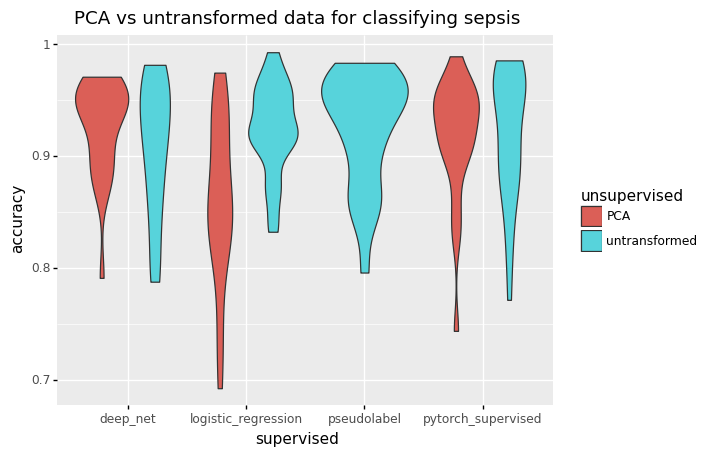

<ggplot: (8763703319510)>


In [9]:
plot = ggplot(sepsis_metrics, aes(x='supervised', y='accuracy', fill='unsupervised')) 
plot += geom_violin()
plot += ggtitle('PCA vs untransformed data for classifying sepsis')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


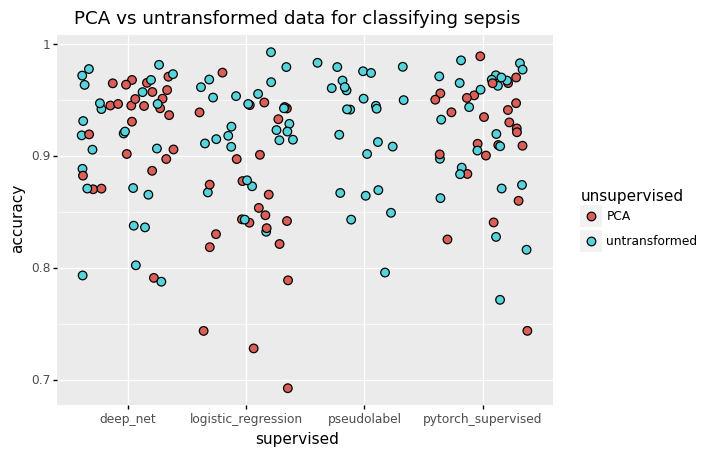

<ggplot: (8763559082162)>


In [10]:
plot = ggplot(sepsis_metrics, aes(x='supervised', y='accuracy', fill='unsupervised')) 
plot += geom_jitter(size=3)
plot += ggtitle('PCA vs untransformed data for classifying sepsis')
print(plot)

## All labels

In [11]:
in_files = glob.glob('../../results/all_labels.*')
in_files = [file for file in in_files if 'be_corrected' not in file]
print(in_files[:5])

['../../results/all_labels.deep_net.refinebio_labeled_dataset.2.tsv', '../../results/all_labels.PCA.logistic_regression.refinebio_labeled_dataset.0.tsv', '../../results/all_labels.deep_net.refinebio_labeled_dataset.0.tsv', '../../results/all_labels.PCA.logistic_regression.refinebio_labeled_dataset.4.tsv', '../../results/all_labels.PCA.deep_net.refinebio_labeled_dataset.1.tsv']


In [12]:
metrics = None
for path in in_files:
    if metrics is None:
        metrics = pd.read_csv(path, sep='\t')
        
        model_info = path.strip('.tsv').split('all_labels.')[-1]
        
        model_info = model_info.split('.')
        
        if len(model_info) == 4:
            unsupervised_model = model_info[0]
            supervised_model = model_info[1]
        else:
            unsupervised_model = 'untransformed'
            supervised_model = model_info[0]
             
        metrics['unsupervised'] = unsupervised_model
        metrics['supervised'] = supervised_model
    else:
        new_df = pd.read_csv(path, sep='\t')
        model_info = path.strip('.tsv').split('all_labels.')[-1]
        model_info = model_info.split('.')
        
        if len(model_info) == 4:
            unsupervised_model = model_info[0]
            supervised_model = model_info[1]
        else:
            unsupervised_model = 'untransformed'
            supervised_model = model_info[0]
             
        new_df['unsupervised'] = unsupervised_model
        new_df['supervised'] = supervised_model
        
        metrics = pd.concat([metrics, new_df])

metrics

,accuracy,train studies,train sample count,unsupervised,supervised
0,0.015056,"GSE15316,GSE9960,GSE51808,GSE84844,GSE45923,GS...",8175,untransformed,deep_net
1,0.019048,"GSE15316,GSE51808,GSE5504,GSE84844,GSE45923,GS...",7189,untransformed,deep_net
2,0.000000,"GSE15316,GSE9960,GSE51808,GSE5504,GSE84844,GSE...",8222,untransformed,deep_net
3,0.041231,"GSE9960,GSE45923,GSE5504,GSE98793,GSE112811,GS...",8512,untransformed,deep_net
4,0.002149,"GSE15316,GSE9960,GSE51808,GSE5504,GSE84844,GSE...",8838,untransformed,deep_net
...,...,...,...,...,...
0,0.002183,"GSE93272,E-MEXP-3567,GSE79150,SRP132709,GSE570...",8402,untransformed,logistic_regression
1,0.070588,"GSE42305,E-MEXP-3567,GSE61240,GSE79150,GSE9327...",8109,untransformed,logistic_regression
2,0.053706,"GSE42305,E-MEXP-3567,GSE61240,SRP132709,GSE791...",7981,untransformed,logistic_regression
3,0.017518,"GSE42305,GSE61240,SRP132709,GSE57065,GSE13015,...",8864,untransformed,logistic_regression


/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


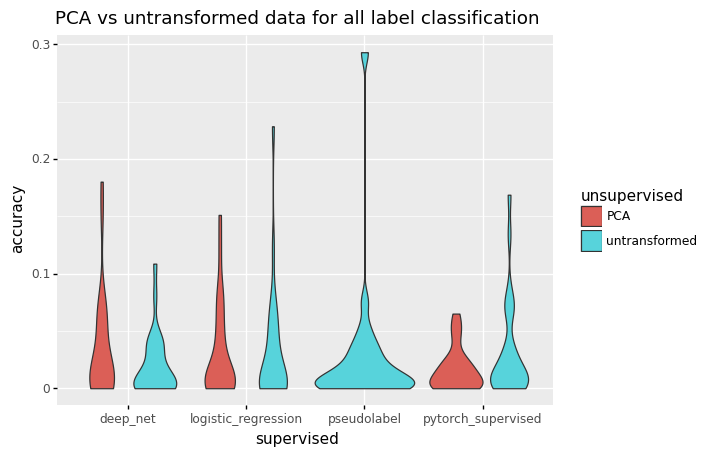

<ggplot: (8763559089171)>


In [13]:
plot = ggplot(metrics, aes(x='supervised', y='accuracy', fill='unsupervised')) 
plot += geom_violin()
plot += ggtitle('PCA vs untransformed data for all label classification')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


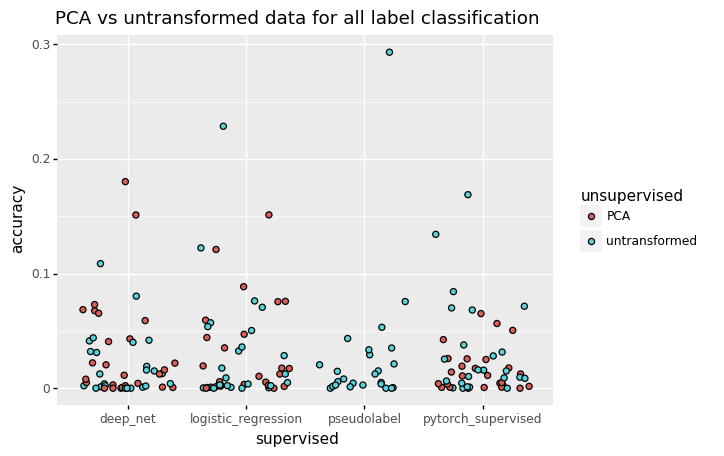

<ggplot: (8763559086553)>


In [14]:
plot = ggplot(metrics, aes(x='supervised', y='accuracy', fill='unsupervised')) 
plot += geom_jitter(size=2)
plot += ggtitle('PCA vs untransformed data for all label classification')
print(plot)

# Subsets of healthy labels

In [15]:
in_files = glob.glob('../../results/subset_label.sepsis*')
in_files = [file for file in in_files if 'be_corrected' not in file]
print(in_files[:5])

['../../results/subset_label.sepsis.pytorch_supervised.refinebio_labeled_dataset.4.tsv', '../../results/subset_label.sepsis.deep_net.refinebio_labeled_dataset.2.tsv', '../../results/subset_label.sepsis.logistic_regression.refinebio_labeled_dataset.3.tsv', '../../results/subset_label.sepsis.PCA.deep_net.refinebio_labeled_dataset.4.tsv', '../../results/subset_label.sepsis.deep_net.refinebio_labeled_dataset.1.tsv']


In [16]:
sepsis_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sepsis.')[-1]
    model_info = model_info.split('.')
        
    if len(model_info) == 4:
        unsupervised_model = model_info[0]
        supervised_model = model_info[1]
    else:
        unsupervised_model = 'untransformed'
        supervised_model = model_info[0]
             
    new_df['unsupervised'] = unsupervised_model
    new_df['supervised'] = supervised_model
        
    sepsis_metrics = pd.concat([sepsis_metrics, new_df])
    
sepsis_metrics = sepsis_metrics.rename({'fraction of healthy used': 'healthy_used'}, axis='columns')
sepsis_metrics['healthy_used'] = sepsis_metrics['healthy_used'].round(1)
    
sepsis_metrics

,accuracy,train studies,train sample count,healthy_used,unsupervised,supervised
0,0.910112,"GSE112811,GSE99039,GSE33341,GSE93606,GSE28750,...",1386,0.1,untransformed,pytorch_supervised
1,0.917431,"GSE112811,GSE99039,GSE33341,GSE50635,GSE93606,...",1548,0.2,untransformed,pytorch_supervised
2,0.923077,"GSE112811,GSE99039,GSE33341,GSE50635,GSE93606,...",1710,0.3,untransformed,pytorch_supervised
3,0.926667,"GSE112811,GSE99039,GSE33341,GSE50635,GSE93606,...",1871,0.4,untransformed,pytorch_supervised
4,0.953216,"GSE112811,GSE99039,GSE33341,GSE50635,GSE93606,...",2033,0.5,untransformed,pytorch_supervised
...,...,...,...,...,...,...
35,0.951087,"GSE33119,GSE65088,GSE98793,GSE66099,GSE50635,G...",1425,0.6,PCA,pytorch_supervised
36,0.978261,"GSE33119,GSE65088,GSE98793,GSE66099,GSE50635,G...",1478,0.7,PCA,pytorch_supervised
37,0.961957,"GSE33119,GSE65088,GSE98793,GSE66099,GSE50635,G...",1530,0.8,PCA,pytorch_supervised
38,0.951087,"GSE33119,GSE65088,GSE98793,GSE66099,GSE50635,G...",1583,0.9,PCA,pytorch_supervised


In [17]:
print(sepsis_metrics[sepsis_metrics['healthy_used'] == 1])

    accuracy                                      train studies  \
9   0.941392  GSE112811,GSE99039,GSE33341,GSE50635,GSE93606,...   
19  0.962919  GSE50635,GSE33341,GSE3284,GSE38511,SRP049820,S...   
29  0.924794  GSE112811,GSE99039,GSE33341,GSE50635,GSE93606,...   
39  0.908333  GSE112811,GSE99039,GSE3284,GSE93606,GSE28750,G...   
49  0.880460  GSE112811,GSE99039,GSE33341,GSE50635,GSE93606,...   
..       ...                                                ...   
39  0.996610  GSE64338,GSE83456,GSE26378,GSE65682,GSE65088,G...   
9   0.909605  GSE65088,GSE42834,GSE37171,GSE98793,GSE50635,S...   
19  1.000000  GSE33119,GSE65088,GSE42834,GSE50635,GSE66099,G...   
29  0.982456  GSE33119,GSE50635,GSE66099,GSE98793,GSE57065,G...   
39  0.961957  GSE33119,GSE65088,GSE98793,GSE66099,GSE50635,G...   

    train sample count  healthy_used   unsupervised           supervised  
9                 2842           1.0  untransformed   pytorch_supervised  
19                2279           1.0  untrans

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


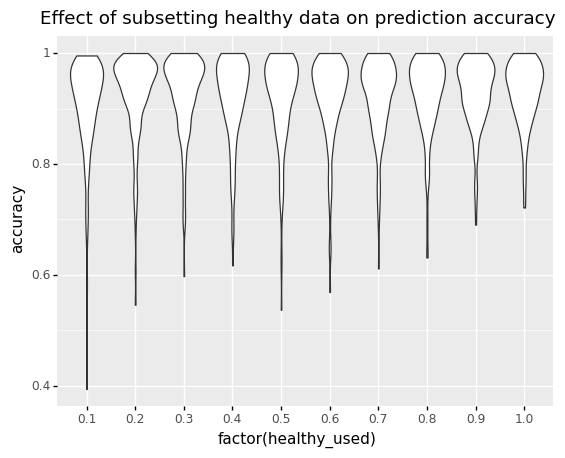

<ggplot: (8763559089520)>


In [18]:
plot = ggplot(sepsis_metrics, aes(x='factor(healthy_used)', y='accuracy', )) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


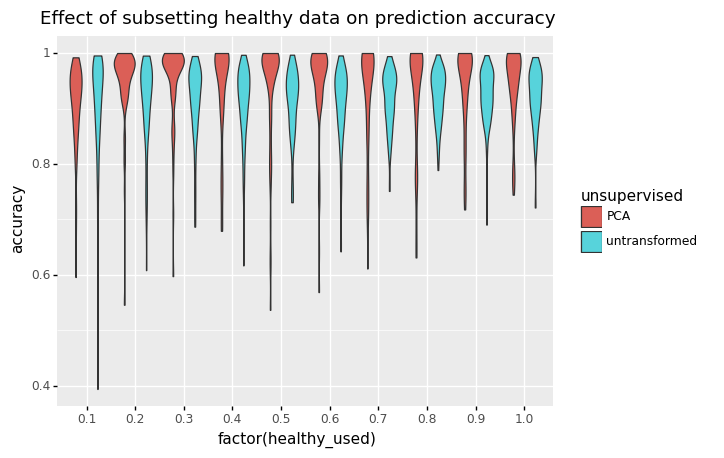

<ggplot: (8763557981859)>


In [19]:
plot = ggplot(sepsis_metrics, aes(x='factor(healthy_used)', y='accuracy', fill='unsupervised')) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


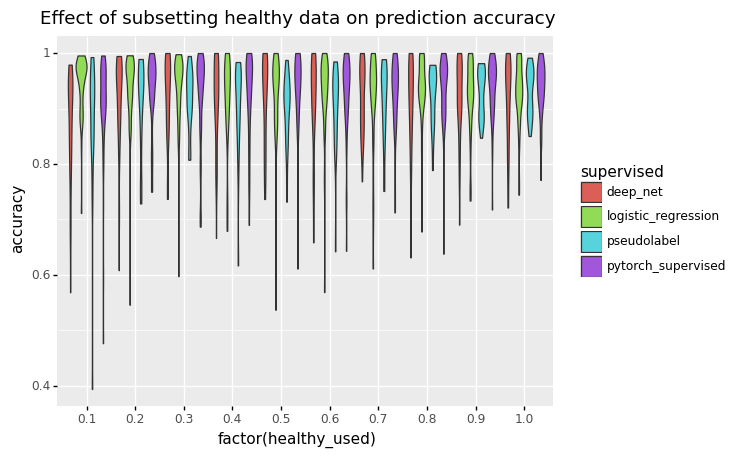

<ggplot: (8763557899024)>


In [20]:
plot = ggplot(sepsis_metrics, aes(x='factor(healthy_used)', y='accuracy', fill='supervised')) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

## Same analysis, but with tb instead of sepsis

In [21]:
in_files = glob.glob('../../results/subset_label.tb*')
in_files = [file for file in in_files if 'be_corrected' not in file]
print(in_files[:5])

['../../results/subset_label.tb.deep_net.refinebio_labeled_dataset.1.tsv', '../../results/subset_label.tb.PCA.pytorch_supervised.refinebio_labeled_dataset.0.tsv', '../../results/subset_label.tb.pytorch_supervised.refinebio_labeled_dataset.3.tsv', '../../results/subset_label.tb.PCA.deep_net.refinebio_labeled_dataset.1.tsv', '../../results/subset_label.tb.PCA.pytorch_supervised.refinebio_labeled_dataset.1.tsv']


In [22]:
tuberculosis_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('tb.')[-1]
    model_info = model_info.split('.')
        
    if len(model_info) == 4:
        unsupervised_model = model_info[0]
        supervised_model = model_info[1]
    else:
        unsupervised_model = 'untransformed'
        supervised_model = model_info[0]
             
    new_df['unsupervised'] = unsupervised_model
    new_df['supervised'] = supervised_model
        
    tuberculosis_metrics = pd.concat([tuberculosis_metrics, new_df])
    
tuberculosis_metrics = tuberculosis_metrics.rename({'fraction of healthy used': 'healthy_used'}, axis='columns')
tuberculosis_metrics['healthy_used'] = tuberculosis_metrics['healthy_used'].round(1)
tuberculosis_metrics

,accuracy,train studies,train sample count,healthy_used,unsupervised,supervised
0,0.676301,"GSE26440,GSE55201,GSE98793,SRP092402,GSE93606,...",771,0.1,untransformed,deep_net
1,0.665025,"GSE26440,GSE55201,GSE98793,SRP092402,GSE93606,...",923,0.2,untransformed,deep_net
2,0.562232,"GSE26440,GSE55201,GSE98793,SRP092402,GSE93606,...",1075,0.3,untransformed,deep_net
3,0.688213,"GSE26440,GSE55201,GSE98793,SRP092402,GSE93606,...",1227,0.4,untransformed,deep_net
4,0.593857,"GSE26440,GSE55201,GSE98793,SRP092402,GSE93606,...",1379,0.5,untransformed,deep_net
...,...,...,...,...,...,...
35,0.493113,"GSE83456,GSE8121,GSE58411,GSE26049,GSE93272,GS...",544,0.6,PCA,pytorch_supervised
36,0.487603,"GSE83456,GSE8121,GSE58411,GSE26049,GSE93272,GS...",569,0.7,PCA,pytorch_supervised
37,0.330579,"GSE83456,GSE8121,GSE58411,GSE26049,GSE93272,GS...",593,0.8,PCA,pytorch_supervised
38,0.584022,"GSE83456,GSE8121,GSE58411,GSE26049,GSE93272,GS...",617,0.9,PCA,pytorch_supervised


In [23]:
print(tuberculosis_metrics[tuberculosis_metrics['healthy_used'] == 1])

    accuracy                                      train studies  \
9   0.726862  GSE26440,GSE55201,GSE98793,SRP092402,GSE93606,...   
19  0.978193  GSE45291,GSE38511,GSE14844,GSE98793,SRP092402,...   
29  0.648780  GSE45291,GSE26440,GSE38511,GSE14844,GSE98793,S...   
39  0.700809  GSE45291,GSE26440,GSE38511,GSE14844,GSE98793,S...   
49  0.647399  GSE45291,GSE26440,GSE38511,GSE14844,GSE55201,G...   
..       ...                                                ...   
49  0.625241  GSE26378,GSE8121,E-MEXP-1635,GSE5504,GSE66099,...   
9   0.000000  GSE83456,GSE8121,GSE4607,SRP071965,GSE99039,GS...   
19  0.613793  GSE83456,GSE8121,GSE4607,GSE99039,GSE65682,GSE...   
29  0.513812  GSE8121,GSE4607,GSE58411,GSE65682,GSE26049,GSE...   
39  0.258953  GSE83456,GSE8121,GSE58411,GSE26049,GSE93272,GS...   

    train sample count  healthy_used   unsupervised          supervised  
9                 2140           1.0  untransformed            deep_net  
19                2262           1.0  untransfo

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


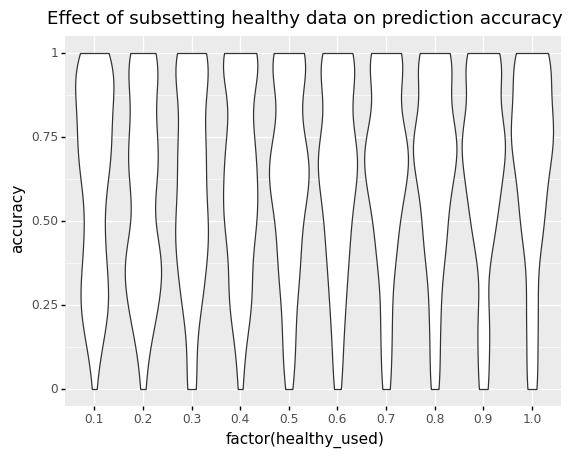

<ggplot: (8763568022845)>


In [24]:
plot = ggplot(tuberculosis_metrics, aes(x='factor(healthy_used)', y='accuracy')) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


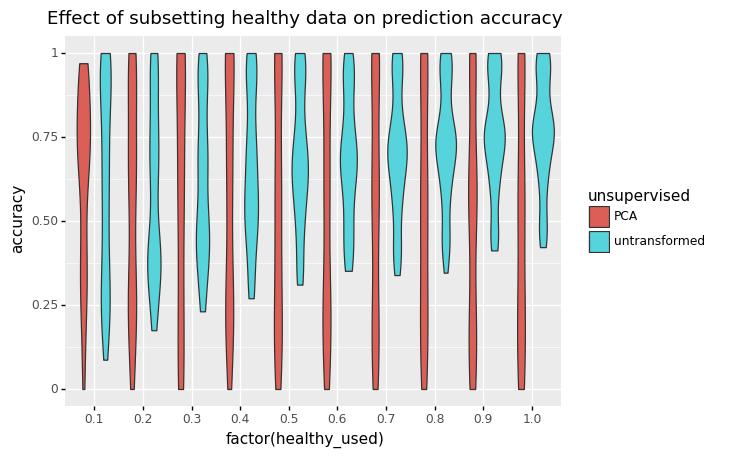

<ggplot: (8763557936695)>


In [25]:
plot = ggplot(tuberculosis_metrics, aes(x='factor(healthy_used)', y='accuracy', fill='unsupervised')) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


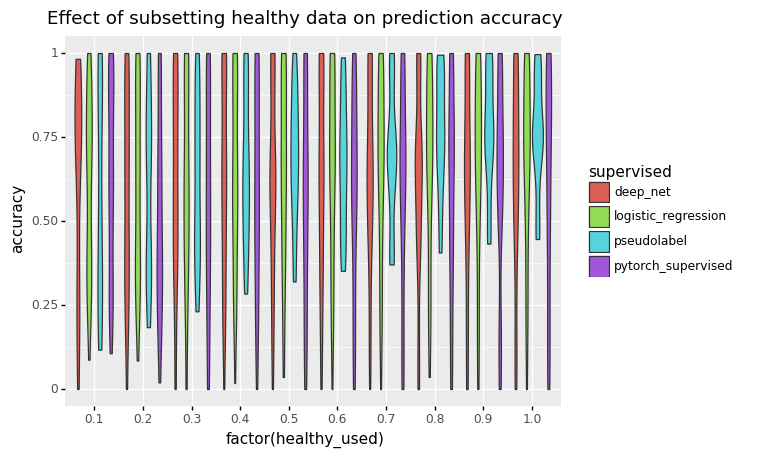

<ggplot: (8763552887890)>


In [26]:
plot = ggplot(tuberculosis_metrics, aes(x='factor(healthy_used)', y='accuracy', fill='supervised')) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

## Supervised Results Only
The results above show that unsupervised learning mostly hurts performance rather than helping.
The visualizations below compare each model based only on its supervised results.

In [27]:
supervised_sepsis = sepsis_metrics[sepsis_metrics['unsupervised'] == 'untransformed']

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


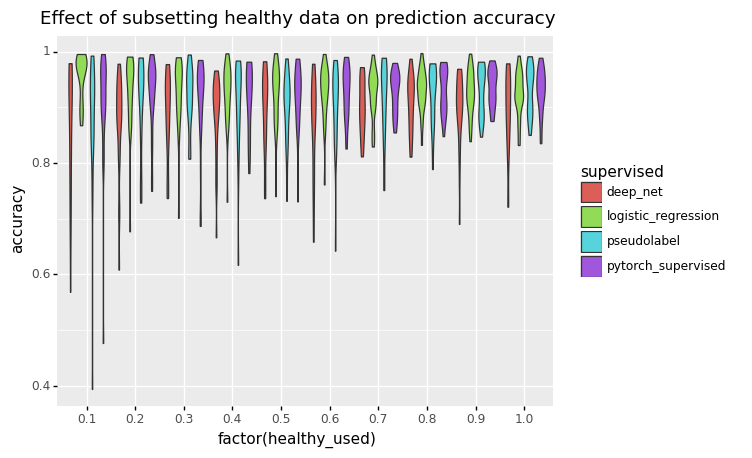

<ggplot: (8763557981712)>


In [28]:
plot = ggplot(supervised_sepsis, aes(x='factor(healthy_used)', y='accuracy', fill='supervised')) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

In [29]:
supervised_tb = tuberculosis_metrics[tuberculosis_metrics['unsupervised'] == 'untransformed']

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


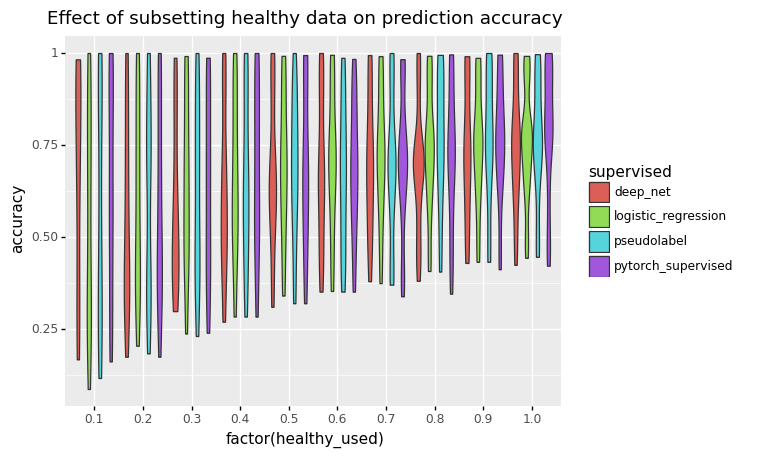

<ggplot: (8763553071008)>


In [30]:
plot = ggplot(supervised_tb, aes(x='factor(healthy_used)', y='accuracy', fill='supervised')) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


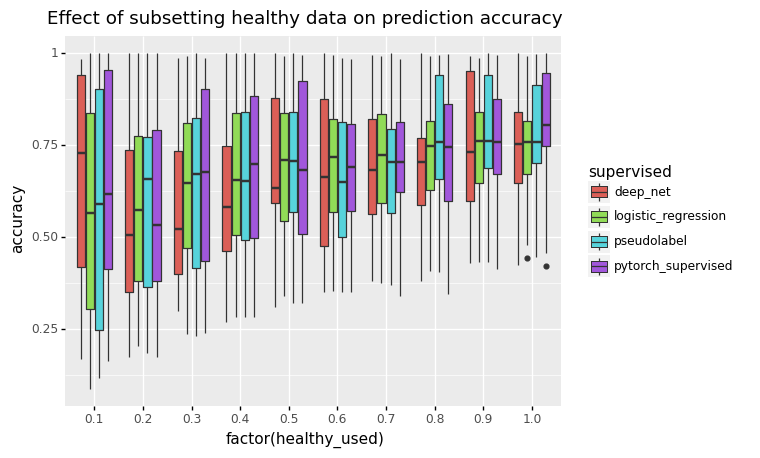

<ggplot: (8763552741732)>


In [31]:
plot = ggplot(supervised_tb, aes(x='factor(healthy_used)', y='accuracy', fill='supervised')) 
plot += geom_boxplot()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

## Batch Effect Correction

In [32]:
in_files = glob.glob('../../results/subset_label.sepsis*be_corrected.tsv')
print(in_files[:5])

['../../results/subset_label.sepsis.pytorch_supervised.refinebio_labeled_dataset.4.be_corrected.tsv', '../../results/subset_label.sepsis.deep_net.refinebio_labeled_dataset.0.be_corrected.tsv', '../../results/subset_label.sepsis.pytorch_supervised.refinebio_labeled_dataset.1.be_corrected.tsv', '../../results/subset_label.sepsis.deep_net.refinebio_labeled_dataset.3.be_corrected.tsv', '../../results/subset_label.sepsis.pytorch_supervised.refinebio_labeled_dataset.2.be_corrected.tsv']


In [33]:
sepsis_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sepsis.')[-1]
    print(model_info)
    model_info = model_info.split('.')
    print(model_info)
        
    supervised_model = model_info[0]
             
    new_df['supervised'] = supervised_model
        
    sepsis_metrics = pd.concat([sepsis_metrics, new_df])
    
sepsis_metrics = sepsis_metrics.rename({'fraction of healthy used': 'healthy_used'}, axis='columns')
sepsis_metrics['healthy_used'] = sepsis_metrics['healthy_used'].round(1)
    
sepsis_metrics

pytorch_supervised.refinebio_labeled_dataset.4.be_corrected
['pytorch_supervised', 'refinebio_labeled_dataset', '4', 'be_corrected']
deep_net.refinebio_labeled_dataset.0.be_corrected
['deep_net', 'refinebio_labeled_dataset', '0', 'be_corrected']
pytorch_supervised.refinebio_labeled_dataset.1.be_corrected
['pytorch_supervised', 'refinebio_labeled_dataset', '1', 'be_corrected']
deep_net.refinebio_labeled_dataset.3.be_corrected
['deep_net', 'refinebio_labeled_dataset', '3', 'be_corrected']
pytorch_supervised.refinebio_labeled_dataset.2.be_corrected
['pytorch_supervised', 'refinebio_labeled_dataset', '2', 'be_corrected']
logistic_regression.refinebio_labeled_dataset.2.be_corrected
['logistic_regression', 'refinebio_labeled_dataset', '2', 'be_corrected']
logistic_regression.refinebio_labeled_dataset.1.be_corrected
['logistic_regression', 'refinebio_labeled_dataset', '1', 'be_corrected']
deep_net.refinebio_labeled_dataset.4.be_corrected
['deep_net', 'refinebio_labeled_dataset', '4', 'be_corr

,accuracy,train studies,train sample count,healthy_used,supervised
0,0.808989,"GSE61635,GSE93606,SRP071965,GSE64338,GSE4607,G...",1386,0.1,pytorch_supervised
1,0.926606,"GSE61635,GSE93606,SRP071965,GSE64338,GSE4607,G...",1548,0.2,pytorch_supervised
2,0.800000,"GSE61635,GSE93606,SRP071965,GSE64338,GSE4607,G...",1710,0.3,pytorch_supervised
3,0.766667,"GSE61635,GSE93606,SRP071965,GSE64338,GSE4607,G...",1871,0.4,pytorch_supervised
4,0.789474,"GSE61635,GSE93606,SRP071965,GSE64338,GSE4607,G...",2033,0.5,pytorch_supervised
...,...,...,...,...,...
45,0.774854,"GSE65682,GSE45923,GSE37171,GSE98583,GSE95233,G...",2044,0.6,pytorch_supervised
46,0.909091,"GSE65682,GSE45923,GSE37171,GSE98583,GSE95233,G...",2194,0.7,pytorch_supervised
47,0.810345,"GSE65682,GSE45923,GSE37171,GSE98583,GSE95233,G...",2344,0.8,pytorch_supervised
48,0.849315,"GSE65682,GSE45923,GSE37171,GSE98583,GSE95233,G...",2494,0.9,pytorch_supervised


/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


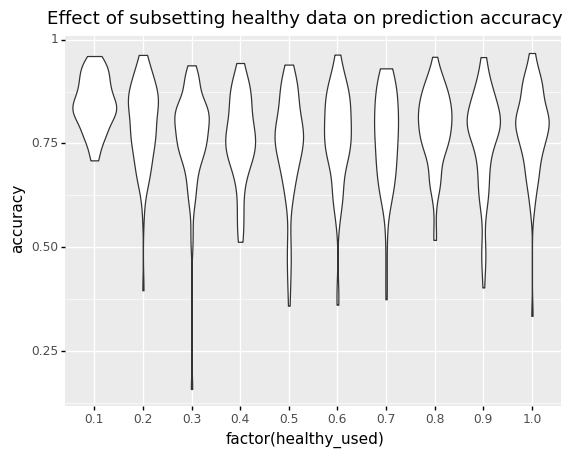

<ggplot: (8763552861904)>


In [34]:
plot = ggplot(sepsis_metrics, aes(x='factor(healthy_used)', y='accuracy', )) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


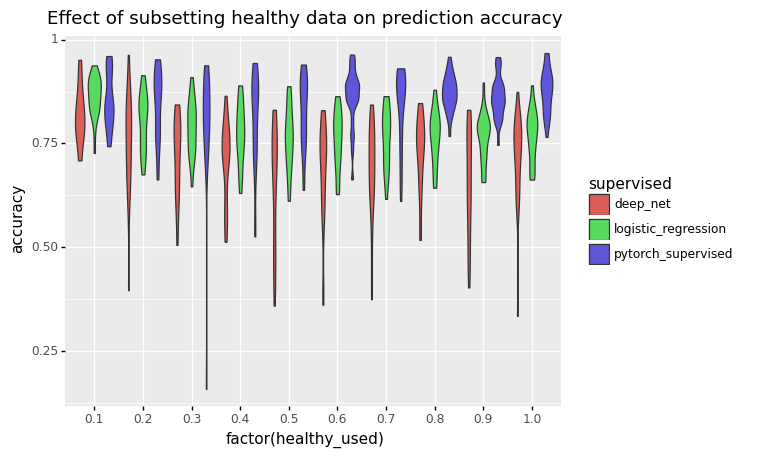

<ggplot: (8763552823971)>


In [35]:
plot = ggplot(sepsis_metrics, aes(x='factor(healthy_used)', y='accuracy', fill='supervised')) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

## TB Batch effect corrected

In [36]:
in_files = glob.glob('../../results/subset_label.tb*be_corrected.tsv')
print(in_files[:5])

['../../results/subset_label.tb.pytorch_supervised.refinebio_labeled_dataset.4.be_corrected.tsv', '../../results/subset_label.tb.logistic_regression.refinebio_labeled_dataset.0.be_corrected.tsv', '../../results/subset_label.tb.deep_net.refinebio_labeled_dataset.4.be_corrected.tsv', '../../results/subset_label.tb.logistic_regression.refinebio_labeled_dataset.2.be_corrected.tsv', '../../results/subset_label.tb.logistic_regression.refinebio_labeled_dataset.4.be_corrected.tsv']


In [37]:
tuberculosis_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('tb.')[-1]
    model_info = model_info.split('.')
        
    supervised_model = model_info[0]
             
    new_df['supervised'] = supervised_model
        
    tuberculosis_metrics = pd.concat([tuberculosis_metrics, new_df])
    
tuberculosis_metrics = tuberculosis_metrics.rename({'fraction of healthy used': 'healthy_used'}, axis='columns')
tuberculosis_metrics['healthy_used'] = tuberculosis_metrics['healthy_used'].round(1)
tuberculosis_metrics

,accuracy,train studies,train sample count,healthy_used,supervised
0,0.762963,"GSE40553,GSE64338,GSE40240,GSE58411,GSE61635,S...",809,0.1,pytorch_supervised
1,0.682635,"GSE40553,GSE64338,GSE40240,GSE58411,GSE3037,GS...",959,0.2,pytorch_supervised
2,0.763819,"GSE40553,GSE64338,GSE40240,GSE58411,GSE3037,GS...",1109,0.3,pytorch_supervised
3,0.740260,"GSE40553,GSE64338,GSE40240,GSE58411,GSE3037,GS...",1259,0.4,pytorch_supervised
4,0.452471,"GSE40553,GSE64338,GSE40240,GSE58411,GSE3037,GS...",1409,0.5,pytorch_supervised
...,...,...,...,...,...
45,0.553991,"SRP077975,GSE14882,GSE3037,GSE40553,GSE33341,G...",1640,0.6,deep_net
46,0.836134,"SRP077975,GSE14882,GSE3037,GSE40553,GSE33341,G...",1798,0.7,deep_net
47,0.778626,"SRP077975,GSE14882,GSE3037,GSE40553,GSE33341,G...",1956,0.8,deep_net
48,0.860140,"SRP077975,GSE14882,GSE3037,GSE40553,GSE33341,G...",2114,0.9,deep_net


/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


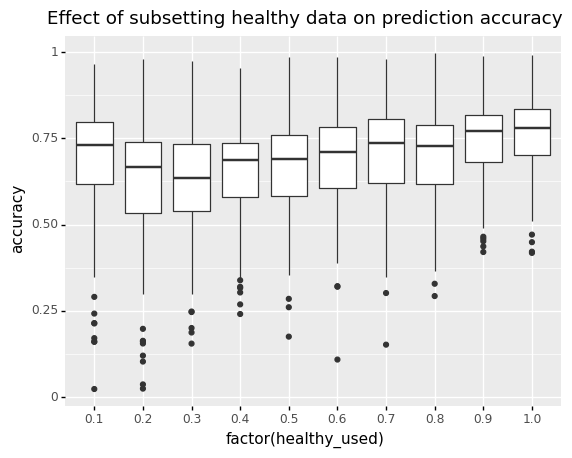

<ggplot: (8763552425963)>


In [38]:
plot = ggplot(tuberculosis_metrics, aes(x='factor(healthy_used)', y='accuracy')) 
plot += geom_boxplot()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


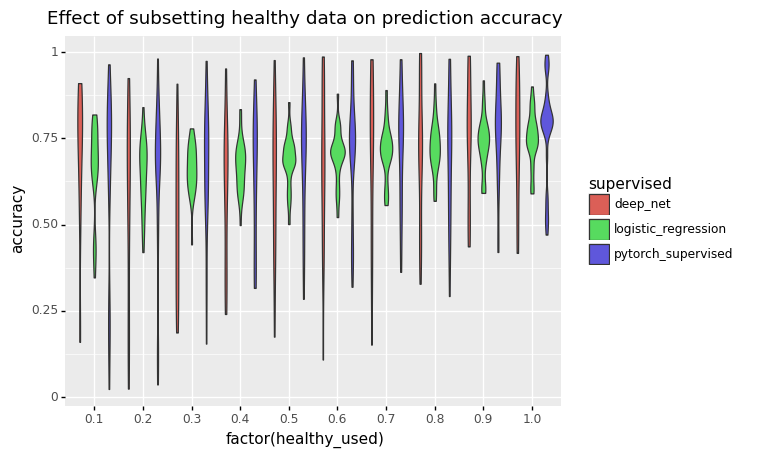

<ggplot: (8763552790351)>


In [39]:
plot = ggplot(tuberculosis_metrics, aes(x='factor(healthy_used)', y='accuracy', fill='supervised')) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

## Better Metrics, Same Label Distribution in Train and Val sets

In [40]:
in_files = glob.glob('../../results/keep_ratios.sepsis*')
print(in_files[:5])

['../../results/keep_ratios.sepsis.logistic_regression.refinebio_labeled_dataset.4.tsv', '../../results/keep_ratios.sepsis.deep_net.refinebio_labeled_dataset.0.tsv', '../../results/keep_ratios.sepsis.logistic_regression.refinebio_labeled_dataset.2.tsv', '../../results/keep_ratios.sepsis.pytorch_supervised.refinebio_labeled_dataset.1.tsv', '../../results/keep_ratios.sepsis.logistic_regression.refinebio_labeled_dataset.0.tsv']


In [41]:
sepsis_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sepsis.')[-1]
    model_info = model_info.split('.')
        
    supervised_model = model_info[0]
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-2]
        
    sepsis_metrics = pd.concat([sepsis_metrics, new_df])
    
sepsis_metrics = sepsis_metrics.rename({'fraction of data used': 'healthy_used'}, axis='columns')
sepsis_metrics['healthy_used'] = sepsis_metrics['healthy_used'].round(1)

# Looking at the training curves, deep_net isn't actually training
# I need to fix it going forward, but for now I can clean up the visualizations by removing it
sepsis_metrics = sepsis_metrics[~(sepsis_metrics['supervised'] == 'deep_net')]
sepsis_metrics

,accuracy,balanced_accuracy,f1_score,train studies,train samples,val samples,train sample count,healthy_used,supervised,seed
0,0.912088,0.859655,0.812500,"GSE28750,GSE57065,GSE26378,GSE95233,GSE26440,G...","GSM1568775,GSM647618,GSM2631191,GSM648598,GSM1...","E-MEXP-3567-C13,E-MEXP-3567-H_C08,E-MEXP-3567-...",216,0.1,logistic_regression,refinebio_labeled_dataset
1,0.912088,0.869246,0.818182,"GSE28750,GSE33118,GSE57065,GSE26378,GSE95233,G...","GSM1568775,GSM647618,GSM2631191,GSM648598,GSM1...","E-MEXP-3567-C13,E-MEXP-3567-H_C08,E-MEXP-3567-...",432,0.2,logistic_regression,refinebio_labeled_dataset
2,0.824176,0.800831,0.684211,"GSE28750,GSE33118,GSE57065,GSE26378,GSE95233,G...","GSM1568775,GSM647618,GSM2631191,GSM648598,GSM1...","E-MEXP-3567-C13,E-MEXP-3567-H_C08,E-MEXP-3567-...",648,0.3,logistic_regression,refinebio_labeled_dataset
3,0.805861,0.774190,0.649007,"GSE28750,GSE33118,GSE57065,GSE26378,GSE95233,G...","GSM1568775,GSM647618,GSM2631191,GSM648598,GSM1...","E-MEXP-3567-C13,E-MEXP-3567-H_C08,E-MEXP-3567-...",865,0.4,logistic_regression,refinebio_labeled_dataset
4,0.813187,0.759910,0.638298,"GSE28750,GSE33118,GSE98583,GSE57065,GSE26378,G...","GSM1568775,GSM647618,GSM2631191,GSM648598,GSM1...","E-MEXP-3567-C13,E-MEXP-3567-H_C08,E-MEXP-3567-...",1081,0.5,logistic_regression,refinebio_labeled_dataset
...,...,...,...,...,...,...,...,...,...,...
45,0.767094,0.813993,0.771488,"SRP071965,GSE57065,GSE98793,GSE14882,GSE112811...","GSM647569,GSM648654,GSM365239,SRR1652976,GSM25...","GSM1100843,GSM1100844,GSM1100845,GSM1100847,GS...",958,0.6,pytorch_supervised,refinebio_labeled_dataset
46,0.880342,0.867616,0.905724,"SRP071965,GSE57065,GSE98793,GSE14882,GSE112811...","GSM647569,GSM648654,GSM365239,SRR1652976,GSM25...","GSM1100843,GSM1100844,GSM1100845,GSM1100847,GS...",1118,0.7,pytorch_supervised,refinebio_labeled_dataset
47,0.878205,0.892374,0.895795,"SRP071965,GSE57065,GSE98793,GSE14882,GSE112811...","GSM647569,GSM648654,GSM365239,SRR1652976,GSM25...","GSM1100843,GSM1100844,GSM1100845,GSM1100847,GS...",1278,0.8,pytorch_supervised,refinebio_labeled_dataset
48,0.867521,0.867733,0.891228,"SRP071965,GSE57065,GSE98793,GSE14882,GSE112811...","GSM647569,GSM648654,GSM365239,SRR1652976,GSM25...","GSM1100843,GSM1100844,GSM1100845,GSM1100847,GS...",1438,0.9,pytorch_supervised,refinebio_labeled_dataset


/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


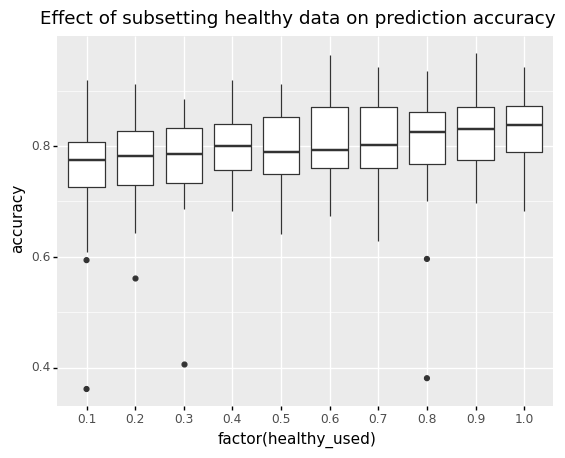

<ggplot: (8763552316103)>


In [42]:
plot = ggplot(sepsis_metrics, aes(x='factor(healthy_used)', y='accuracy')) 
plot += geom_boxplot()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


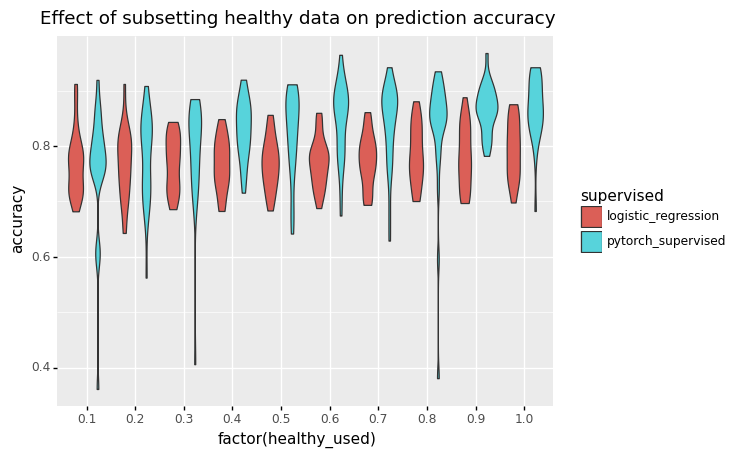

<ggplot: (8763552532438)>


In [43]:
plot = ggplot(sepsis_metrics, aes(x='factor(healthy_used)', y='accuracy', fill='supervised')) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


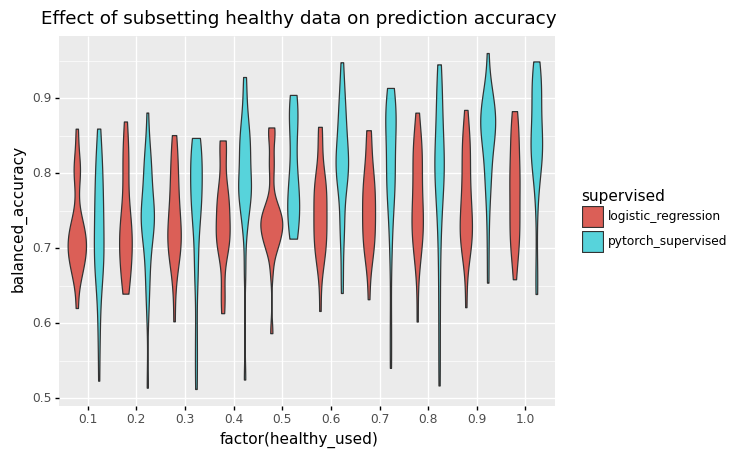

<ggplot: (8763552316103)>


In [44]:
plot = ggplot(sepsis_metrics, aes(x='factor(healthy_used)', y='balanced_accuracy', fill='supervised')) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

In [45]:
sepsis_stat_df = create_dataset_stat_df(sepsis_metrics, 
                                        sample_to_study, 
                                        sample_metadata, 
                                        sample_to_label,
                                        'sepsis')

sepsis_stat_df.tail(5)

,train_disease_count,train_healthy_count,val_disease_count,val_healthy_count,accuracy,balanced_accuracy,subset_fraction,seed,model,train_disease_percent,val_disease_percent,train_val_diff,train_count
495,601,357,293,175,0.767094,0.813993,0.6,refinebio_labeled_dataset,pytorch_supervised,0.627349,0.626068,0.001280,958
496,698,420,293,175,0.880342,0.867616,0.7,refinebio_labeled_dataset,pytorch_supervised,0.624329,0.626068,0.001739,1118
497,804,474,293,175,0.878205,0.892374,0.8,refinebio_labeled_dataset,pytorch_supervised,0.629108,0.626068,0.003040,1278
498,900,538,293,175,0.867521,0.867733,0.9,refinebio_labeled_dataset,pytorch_supervised,0.625869,0.626068,0.000199,1438
499,1001,597,293,175,0.867521,0.858528,1.0,refinebio_labeled_dataset,pytorch_supervised,0.626408,0.626068,0.000340,1598


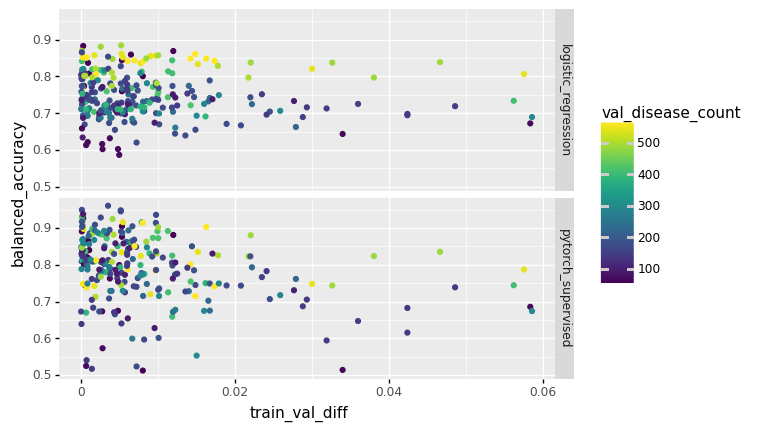

<ggplot: (8763552415356)>

In [46]:
ggplot(sepsis_stat_df, aes(x='train_val_diff', 
                           y='balanced_accuracy', 
                           color='val_disease_count')) + geom_point() + facet_grid('model ~ .')

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


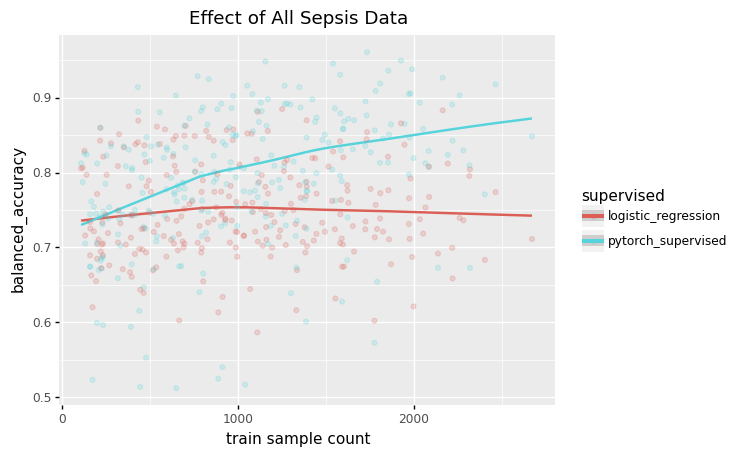

<ggplot: (8763552199647)>

In [47]:
plot = ggplot(sepsis_metrics, aes(x='train sample count', y='balanced_accuracy', color='supervised')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += ggtitle('Effect of All Sepsis Data')
plot

## Same Distribution Tuberculosis

In [48]:
in_files = glob.glob('../../results/keep_ratios.tb*')
print(in_files[:5])

['../../results/keep_ratios.tb.logistic_regression.refinebio_labeled_dataset.0.tsv', '../../results/keep_ratios.tb.pytorch_supervised.refinebio_labeled_dataset.1.tsv', '../../results/keep_ratios.tb.deep_net.refinebio_labeled_dataset.2.tsv', '../../results/keep_ratios.tb.logistic_regression.refinebio_labeled_dataset.1.tsv', '../../results/keep_ratios.tb.deep_net.refinebio_labeled_dataset.3.tsv']


In [49]:
tb_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('tb.')[-1]
    model_info = model_info.split('.')
        
    supervised_model = model_info[0]
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-2]
        
    tb_metrics = pd.concat([tb_metrics, new_df])
    
tb_metrics = tb_metrics.rename({'fraction of data used': 'healthy_used'}, axis='columns')
tb_metrics['healthy_used'] = tb_metrics['healthy_used'].round(1)
tb_metrics

,accuracy,balanced_accuracy,f1_score,train studies,train samples,val samples,train sample count,healthy_used,supervised,seed
0,0.714834,0.727415,0.726380,"E-MEXP-1635,GSE26378,GSE40553,GSE58411,GSE5180...","GSM777379,GSM996438,SRR3745139,GSM1892930,GSM2...","GSM1100843,GSM1100844,GSM1100845,GSM1100847,GS...",52,0.1,logistic_regression,refinebio_labeled_dataset
1,0.653453,0.686282,0.619916,"GSE51808,GSE38511,GSE64338,E-MEXP-1635,GSE9879...","GSM777379,GSM996438,SRR3745139,GSM1892930,GSM2...","GSM1100843,GSM1100844,GSM1100845,GSM1100847,GS...",105,0.2,logistic_regression,refinebio_labeled_dataset
2,0.717391,0.732194,0.725466,"GSE26440,GSE37171,GSE51808,GSE38511,GSE64338,E...","GSM777379,GSM996438,SRR3745139,GSM1892930,GSM2...","GSM1100843,GSM1100844,GSM1100845,GSM1100847,GS...",158,0.3,logistic_regression,refinebio_labeled_dataset
3,0.746803,0.762631,0.753731,"GSE26440,GSE37171,GSE51808,GSE84844,GSE38511,G...","GSM777379,GSM996438,SRR3745139,GSM1892930,GSM2...","GSM1100843,GSM1100844,GSM1100845,GSM1100847,GS...",210,0.4,logistic_regression,refinebio_labeled_dataset
4,0.732737,0.750543,0.736444,"GSE26440,GSE37171,GSE51808,GSE84844,GSE32198,G...","GSM777379,GSM996438,SRR3745139,GSM1892930,GSM2...","GSM1100843,GSM1100844,GSM1100845,GSM1100847,GS...",263,0.5,logistic_regression,refinebio_labeled_dataset
...,...,...,...,...,...,...,...,...,...,...
35,0.612524,0.614470,0.560000,"GSE33580,GSE25504,GSE39088,GSE64338,GSE11909,G...","GSM996367,GSM912842,SRR3235929,GSM824762,SRR47...","GSM1050948,GSM1050971,GSM1050988,GSM1050991,GS...",849,0.6,pytorch_supervised,refinebio_labeled_dataset
36,0.808219,0.764283,0.695652,"GSE33580,GSE25504,GSE39088,GSE64338,GSE11909,G...","GSM996367,GSM912842,SRR3235929,GSM824762,SRR47...","GSM1050948,GSM1050971,GSM1050988,GSM1050991,GS...",991,0.7,pytorch_supervised,refinebio_labeled_dataset
37,0.796477,0.754574,0.682927,"GSE33580,GSE25504,GSE39088,GSE64338,GSE11909,G...","GSM996367,GSM912842,SRR3235929,GSM824762,SRR47...","GSM1050948,GSM1050971,GSM1050988,GSM1050991,GS...",1132,0.8,pytorch_supervised,refinebio_labeled_dataset
38,0.780822,0.739915,0.662651,"GSE33580,GSE25504,GSE39088,GSE64338,GSE11909,G...","GSM996367,GSM912842,SRR3235929,GSM824762,SRR47...","GSM1050948,GSM1050971,GSM1050988,GSM1050991,GS...",1274,0.9,pytorch_supervised,refinebio_labeled_dataset


/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


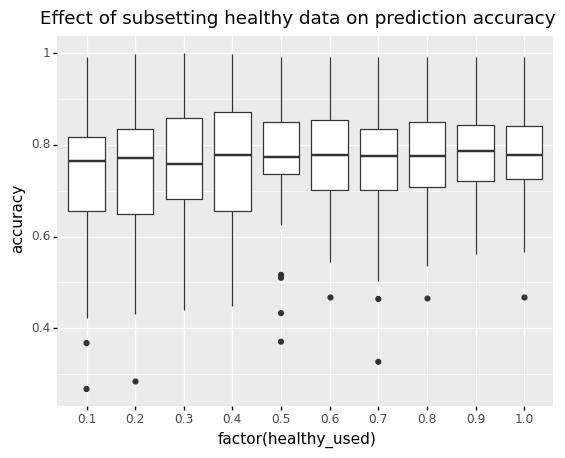

<ggplot: (8763552271165)>


In [50]:
plot = ggplot(tb_metrics, aes(x='factor(healthy_used)', y='accuracy')) 
plot += geom_boxplot()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


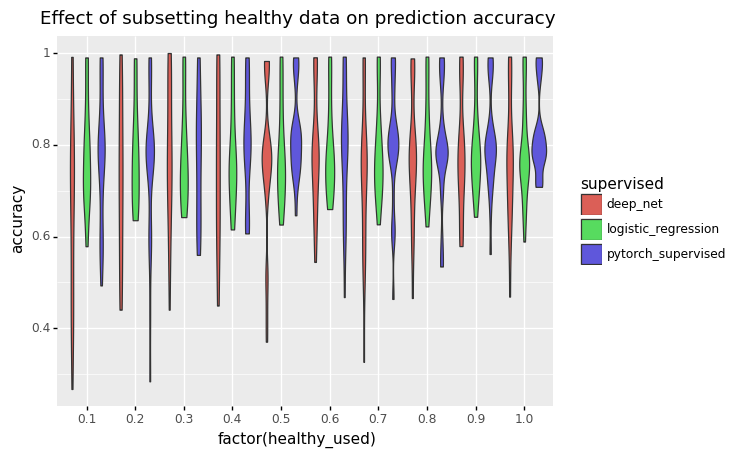

<ggplot: (8763552361192)>


In [51]:
plot = ggplot(tb_metrics, aes(x='factor(healthy_used)', y='accuracy', fill='supervised')) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


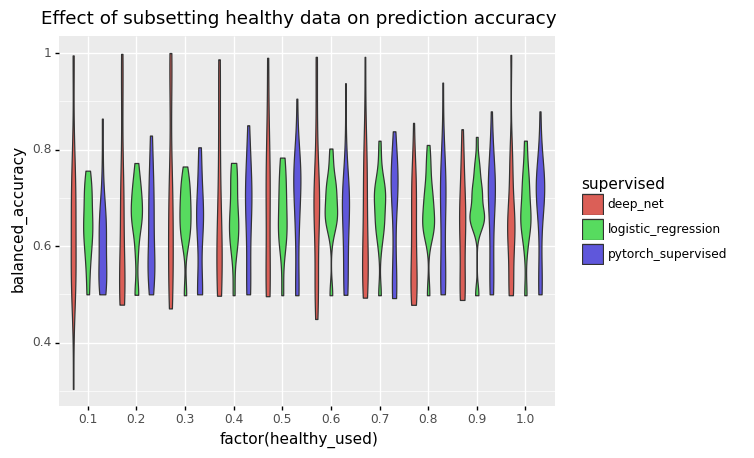

<ggplot: (8763552104885)>


In [52]:
plot = ggplot(tb_metrics, aes(x='factor(healthy_used)', y='balanced_accuracy', fill='supervised')) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

In [53]:
tb_stat_df = create_dataset_stat_df(tb_metrics, 
                                    sample_to_study, 
                                    sample_metadata, 
                                    sample_to_label,
                                    'tb')

tb_stat_df.tail(5)

,train_disease_count,train_healthy_count,val_disease_count,val_healthy_count,accuracy,balanced_accuracy,subset_fraction,seed,model,train_disease_percent,val_disease_percent,train_val_diff,train_count
655,327,522,202,309,0.612524,0.614470,0.6,refinebio_labeled_dataset,pytorch_supervised,0.385159,0.395303,0.010144,849
656,391,600,202,309,0.808219,0.764283,0.7,refinebio_labeled_dataset,pytorch_supervised,0.394551,0.395303,0.000752,991
657,456,676,202,309,0.796477,0.754574,0.8,refinebio_labeled_dataset,pytorch_supervised,0.402827,0.395303,0.007524,1132
658,503,771,202,309,0.780822,0.739915,0.9,refinebio_labeled_dataset,pytorch_supervised,0.394819,0.395303,0.000484,1274
659,560,856,202,309,0.792564,0.747909,1.0,refinebio_labeled_dataset,pytorch_supervised,0.395480,0.395303,0.000177,1416


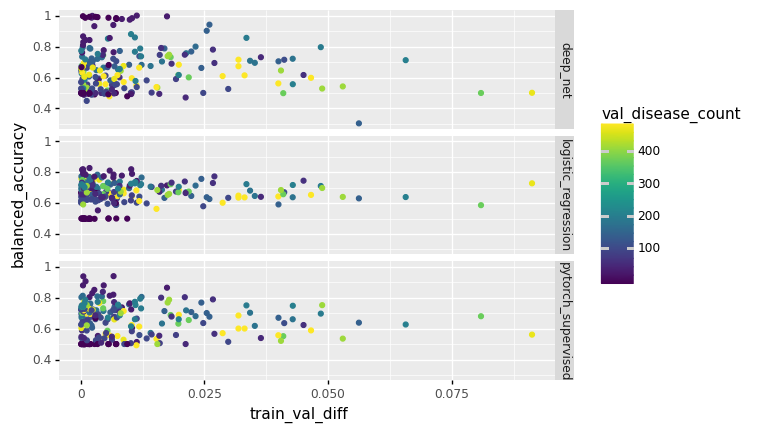

<ggplot: (8763552271144)>

In [54]:
ggplot(tb_stat_df, aes(x='train_val_diff', 
                       y='balanced_accuracy', 
                       color='val_disease_count')) + geom_point() + facet_grid('model ~ .')

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


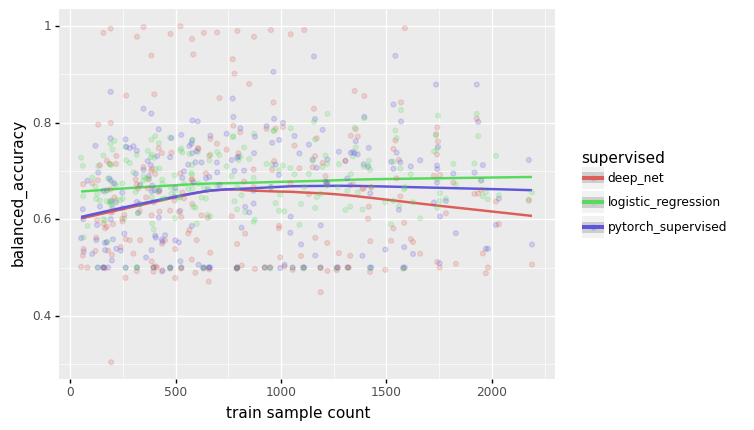

<ggplot: (8763551883876)>

In [55]:
plot = ggplot(tb_metrics, aes(x='train sample count', y='balanced_accuracy', color='supervised')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot

## Results from Small Datasets

In [56]:
in_files = glob.glob('../../results/small_subsets.sepsis*')
print(in_files[:5])

['../../results/small_subsets.sepsis.logistic_regression.refinebio_labeled_dataset.3.tsv', '../../results/small_subsets.sepsis.deep_net.refinebio_labeled_dataset.2.tsv', '../../results/small_subsets.sepsis.deep_net.refinebio_labeled_dataset.4.tsv', '../../results/small_subsets.sepsis.pytorch_supervised.refinebio_labeled_dataset.3.tsv', '../../results/small_subsets.sepsis.logistic_regression.refinebio_labeled_dataset.2.tsv']


In [57]:
sepsis_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sepsis.')[-1]
    model_info = model_info.split('.')
        
    supervised_model = model_info[0]
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-2]
        
    sepsis_metrics = pd.concat([sepsis_metrics, new_df])
    
sepsis_metrics['train_count'] = sepsis_metrics['train sample count']

# Looking at the training curves, deep_net isn't actually training
# I need to fix it going forward, but for now I can clean up the visualizations by removing it
sepsis_metrics = sepsis_metrics[~(sepsis_metrics['supervised'] == 'deep_net')]
sepsis_metrics

,accuracy,balanced_accuracy,f1_score,train studies,train samples,val samples,train sample count,supervised,seed,train_count
0,0.679435,0.679435,0.561983,"GSE19491,GSE32198,SRP092402,GSE11755,GSE95233,...","GSM264992,GSM1617681,GSM1586944,GSM350349,GSM1...","E-MEXP-1635-04SE57HA300104,E-MEXP-1635-04SE58H...",20,logistic_regression,refinebio_labeled_dataset,20
1,0.711694,0.711694,0.666667,"SRP092402,GSE84844,GSE57065,GSE61635,GSE83456,...","GSM264992,GSM1617681,GSM1586944,GSM350349,GSM1...","E-MEXP-1635-04SE57HA300104,E-MEXP-1635-04SE58H...",40,logistic_regression,refinebio_labeled_dataset,40
2,0.701613,0.701613,0.695473,"SRP092402,GSE84844,GSE57065,GSE61635,GSE83456,...","GSM264992,GSM1617681,GSM1586944,GSM350349,GSM1...","E-MEXP-1635-04SE57HA300104,E-MEXP-1635-04SE58H...",60,logistic_regression,refinebio_labeled_dataset,60
3,0.687500,0.687500,0.672304,"SRP092402,GSE84844,GSE57065,GSE61635,GSE83456,...","GSM264992,GSM1617681,GSM1586944,GSM350349,GSM1...","E-MEXP-1635-04SE57HA300104,E-MEXP-1635-04SE58H...",80,logistic_regression,refinebio_labeled_dataset,80
4,0.691532,0.691532,0.663736,"SRP092402,GSE11909,GSE84844,GSE57065,GSE61635,...","GSM264992,GSM1617681,GSM1586944,GSM350349,GSM1...","E-MEXP-1635-04SE57HA300104,E-MEXP-1635-04SE58H...",100,logistic_regression,refinebio_labeled_dataset,100
...,...,...,...,...,...,...,...,...,...,...
90,0.583333,0.583333,0.702602,"GSE98583,GSE80060,GSE9960,GSE45291,GSE45923,GS...","GSM648655,GSM2500376,GSM251944,GSM350358,GSM35...","GSM1404211,GSM1404212,GSM1404219,GSM1404220,GS...",300,pytorch_supervised,refinebio_labeled_dataset,300
91,0.744792,0.744792,0.701220,"GSE98583,GSE80060,GSE9960,GSE45291,GSE45923,GS...","GSM648655,GSM2500376,GSM251944,GSM350358,GSM35...","GSM1404211,GSM1404212,GSM1404219,GSM1404220,GS...",320,pytorch_supervised,refinebio_labeled_dataset,320
92,0.718750,0.718750,0.774530,"GSE98583,GSE80060,GSE9960,GSE45291,GSE45923,GS...","GSM648655,GSM2500376,GSM251944,GSM350358,GSM35...","GSM1404211,GSM1404212,GSM1404219,GSM1404220,GS...",340,pytorch_supervised,refinebio_labeled_dataset,340
93,0.773438,0.773438,0.773438,"GSE98583,GSE80060,GSE9960,GSE45291,GSE45923,GS...","GSM648655,GSM2500376,GSM251944,GSM350358,GSM35...","GSM1404211,GSM1404212,GSM1404219,GSM1404220,GS...",360,pytorch_supervised,refinebio_labeled_dataset,360


/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


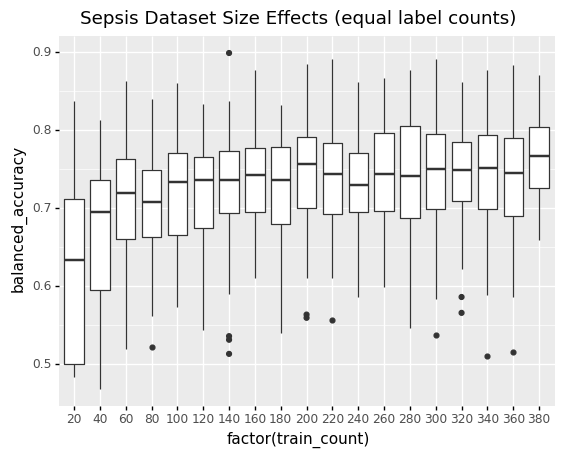

<ggplot: (8763552104903)>


In [58]:
plot = ggplot(sepsis_metrics, aes(x='factor(train_count)', y='balanced_accuracy')) 
plot += geom_boxplot()
plot += ggtitle('Sepsis Dataset Size Effects (equal label counts)')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


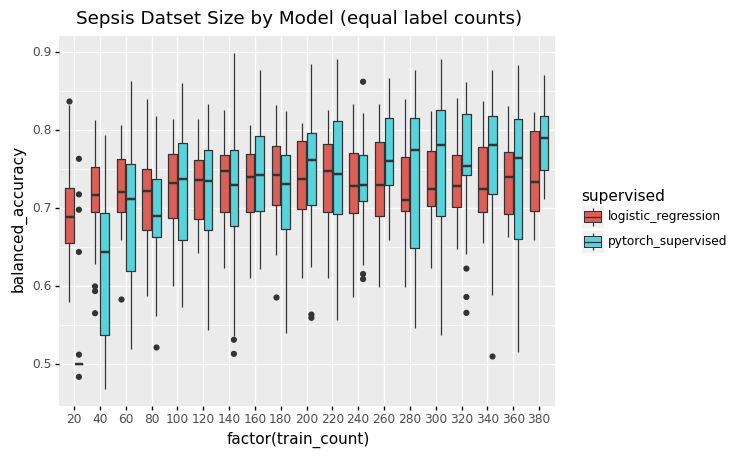

<ggplot: (8763551852942)>


In [59]:
plot = ggplot(sepsis_metrics, aes(x='factor(train_count)', y='balanced_accuracy', fill='supervised')) 
plot += geom_boxplot()
plot += ggtitle('Sepsis Datset Size by Model (equal label counts)')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


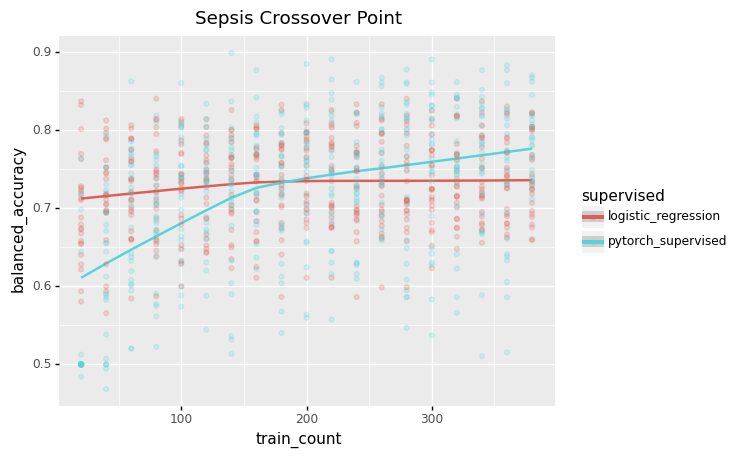

<ggplot: (8763551765595)>

In [60]:
plot = ggplot(sepsis_metrics, aes(x='train_count', y='balanced_accuracy', color='supervised')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += ggtitle('Sepsis Crossover Point')
plot

## Small Training Set TB

In [61]:
in_files = glob.glob('../../results/small_subsets.tb*')
print(in_files[:5])

['../../results/small_subsets.tb.pytorch_supervised.refinebio_labeled_dataset.1.tsv', '../../results/small_subsets.tb.pytorch_supervised.refinebio_labeled_dataset.2.tsv', '../../results/small_subsets.tb.logistic_regression.refinebio_labeled_dataset.2.tsv', '../../results/small_subsets.tb.deep_net.refinebio_labeled_dataset.0.tsv', '../../results/small_subsets.tb.pytorch_supervised.refinebio_labeled_dataset.3.tsv']


In [62]:
tb_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('tb.')[-1]
    model_info = model_info.split('.')
        
    supervised_model = model_info[0]
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-2]
        
    tb_metrics = pd.concat([tb_metrics, new_df])
    
tb_metrics['train_count'] = tb_metrics['train sample count']

# Looking at the training curves, deep_net isn't actually training
# I need to fix it going forward, but for now I can clean up the visualizations by removing it
tb_metrics = tb_metrics[~(tb_metrics['supervised'] == 'deep_net')]
tb_metrics

,accuracy,balanced_accuracy,f1_score,train studies,train samples,val samples,train sample count,supervised,seed,train_count
0,0.604895,0.604895,0.368715,"GSE99039,SRP092402,GSE73408,GSE19491,SRP071965...","GSM484628,SRR4785064,GSM1892936,SRR4784236,GSM...","GSM2203540,GSM2203541,GSM2203542,GSM2203543,GS...",20,pytorch_supervised,refinebio_labeled_dataset,20
1,0.636364,0.636364,0.440860,"GSE99039,GSE95233,E-MEXP-1635,SRP092402,GSE734...","GSM484628,SRR4785064,GSM1892936,SRR4784236,GSM...","GSM2203540,GSM2203541,GSM2203542,GSM2203543,GS...",40,pytorch_supervised,refinebio_labeled_dataset,40
2,0.548951,0.548951,0.652291,"GSE99039,GSE95233,E-MEXP-1635,SRP092402,GSE734...","GSM484628,SRR4785064,GSM1892936,SRR4784236,GSM...","GSM2203540,GSM2203541,GSM2203542,GSM2203543,GS...",60,pytorch_supervised,refinebio_labeled_dataset,60
3,0.590909,0.590909,0.670423,"GSE99039,GSE73408,GSE3037,GSE19491,GSE39088,GS...","GSM484628,SRR4785064,GSM1892936,SRR4784236,GSM...","GSM2203540,GSM2203541,GSM2203542,GSM2203543,GS...",80,pytorch_supervised,refinebio_labeled_dataset,80
4,0.688811,0.688811,0.565854,"GSE99039,GSE73408,GSE3037,GSE19491,GSE39088,GS...","GSM484628,SRR4785064,GSM1892936,SRR4784236,GSM...","GSM2203540,GSM2203541,GSM2203542,GSM2203543,GS...",100,pytorch_supervised,refinebio_labeled_dataset,100
...,...,...,...,...,...,...,...,...,...,...
90,1.000000,1.000000,1.000000,"GSE45291,GSE13904,GSE58411,GSE93777,GSE3491,GS...","SRR4785022,SRR4785088,GSM2203581,SRR4784602,GS...","SRR3745139,SRR3745147,SRR3745171,SRR3745172,SR...",300,logistic_regression,refinebio_labeled_dataset,300
91,1.000000,1.000000,1.000000,"GSE45291,GSE13904,GSE58411,GSE93777,GSE3491,GS...","SRR4785022,SRR4785088,GSM2203581,SRR4784602,GS...","SRR3745139,SRR3745147,SRR3745171,SRR3745172,SR...",320,logistic_regression,refinebio_labeled_dataset,320
92,1.000000,1.000000,1.000000,"GSE45291,GSE13904,GSE58411,GSE93777,GSE3491,GS...","SRR4785022,SRR4785088,GSM2203581,SRR4784602,GS...","SRR3745139,SRR3745147,SRR3745171,SRR3745172,SR...",340,logistic_regression,refinebio_labeled_dataset,340
93,1.000000,1.000000,1.000000,"GSE45291,GSE13904,GSE58411,GSE93777,GSE3491,GS...","SRR4785022,SRR4785088,GSM2203581,SRR4784602,GS...","SRR3745139,SRR3745147,SRR3745171,SRR3745172,SR...",360,logistic_regression,refinebio_labeled_dataset,360


/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


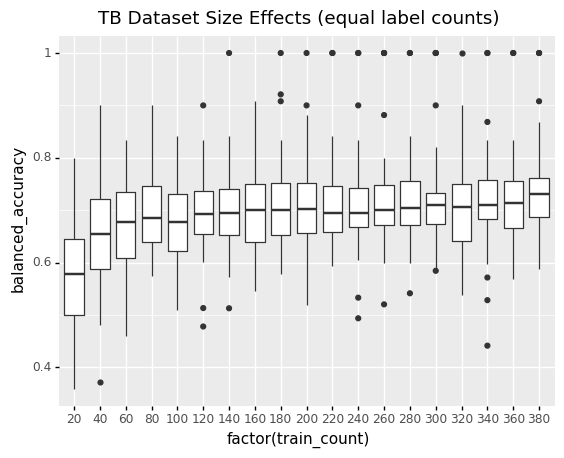

<ggplot: (8763552104855)>


In [63]:
plot = ggplot(tb_metrics, aes(x='factor(train_count)', y='balanced_accuracy')) 
plot += geom_boxplot()
plot += ggtitle('TB Dataset Size Effects (equal label counts)')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


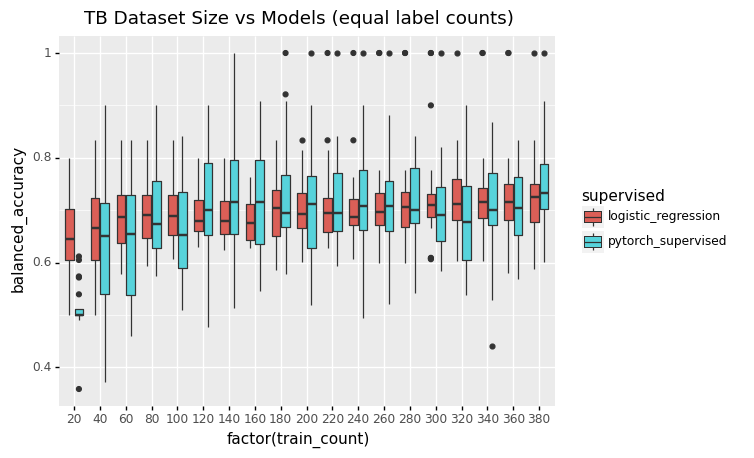

<ggplot: (8763551632659)>


In [64]:
plot = ggplot(tb_metrics, aes(x='factor(train_count)', y='balanced_accuracy', fill='supervised')) 
plot += geom_boxplot()
plot += ggtitle('TB Dataset Size vs Models (equal label counts)')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


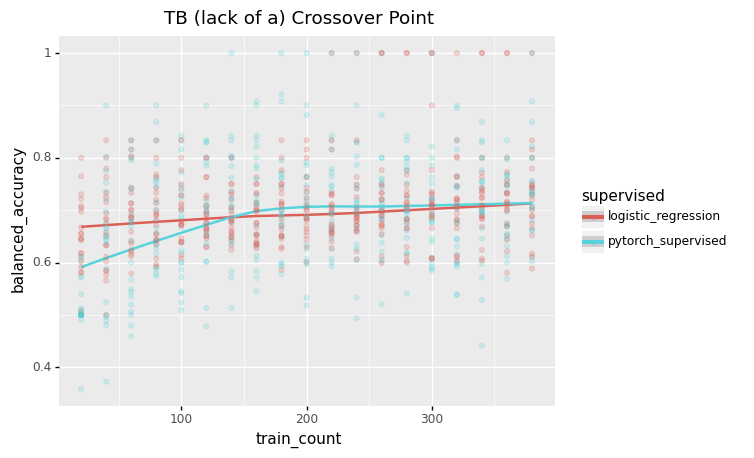

<ggplot: (8763551509836)>

In [65]:
plot = ggplot(tb_metrics, aes(x='train_count', y='balanced_accuracy', color='supervised')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += ggtitle('TB (lack of a) Crossover Point')
plot